In [1]:
# Copyright (c) 2025, ETH Zurich

In [ ]:
import os
import pathlib
import datetime

In [2]:
# This cell is tagged `parameters`
system = "<FOLDER NAME GIBCT>"
system_abct = "<FOLDER NAME NUVIEW>"
system_static = "<FOLDER NAME OPTICA>"
sample_size_cm = 9
binning = 2
storage = "<PATH TO STORAGE OF THE FOLDERS>"

# Initialization

In [3]:
%matplotlib inline

In [4]:
import glob
import os

import numpy as np
import scipy
import scipy.constants as cnst
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage as ski
import xarray as xr
import tomopy
import astra

import sys
import spekpy as sp

import skimage
from scipy import interpolate
import skimage.io as io
import xraydb

import xraydb
import json

In [103]:
# matplotlib style
plt.style.use("default")

# set FIGWIDTH to latex's \textwidth
FIGWIDTH = 3
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 5
plt.rcParams["figure.figsize"] = (FIGWIDTH, FIGWIDTH * 2 / 3)
plt.rcParams["figure.dpi"] = 600
plt.rcParams["figure.constrained_layout.use"] = "True"

# images
plt.rcParams["image.interpolation"] = "bicubic"
plt.rcParams["image.cmap"] = "Greys_r"

# axes
# plt.rcParams["axes.spines.right"] = False
# plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.edgecolor"] = "0.7"
plt.rcParams["axes.linewidth"] = "1"

# legend
plt.rcParams["legend.frameon"] = False

plt.rcParams["lines.markersize"] = 1
# plt.rcParams["lines.markerfacecolor"] = "white"
# Okabe-Ito palette
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=[
        "#000000",
        "#E69F00",
        "#56B4E9",
        "#009E73",
        "#F0E442",
        "#0072B2",
        "#D55E00",
        "#CC79A7",
    ],
    #marker=None #["o", "^", "s", "p", "D", "v", "v", "d"],
)

plt.rcParams['axes.grid'] = False

# Funtionalities for CNR calculation

In [104]:
def get_mask_span(m):
    x0 = m.any(axis=0).nonzero()[0][0]
    x1 = m.any(axis=0).nonzero()[0][-1]
    y0 = m.any(axis=1).nonzero()[0][0]
    y1 = m.any(axis=1).nonzero()[0][-1]

    #print(x0, x1, y0, y1)
    return y0, y1, x0, x1

def get_mask_sel(m, margin=0):
    y0, y1, x0, x1 = get_mask_span(m)

    return np.s_[..., (y0 - margin) : (y1 + margin + 1), (x0 - margin) : (x1 + margin + 1)]

idx_row = 4

### Functions for image fusion
def normalise(d, m1, m2, ref):
    s1 = get_mask_sel(m1, margin=0)
    s2 = get_mask_sel(m2, margin=0)

    v1 = ref[:][s1].mean()
    v2 = ref[:][s2].mean()

    return (d - v1) / (v2 - v1)

def fuse(d1, d2, sigma):
    d1f = scipy.ndimage.gaussian_filter(d1, sigma=[0, sigma, sigma])
    d2f = d2 - scipy.ndimage.gaussian_filter(d2, sigma=[0, sigma, sigma])

    return d1f + d2f


def fuse_abs(d1, d2, sigma, m1):
    d1f = scipy.ndimage.gaussian_filter(d1, sigma = [0, sigma, sigma])
    d2f = d2 - scipy.ndimage.gaussian_filter(d2, sigma = [0, sigma, sigma])
    s1 = get_mask_sel(m1, margin = 0)
    v1 = d1f[:][s1].mean()
    v2 = d2[:][s1].mean()
    
    return d1f + 2* d2f * v1 / v2

def fuse_normalized(d1, d2, sigma, m1, attenuation):
    d1f = scipy.ndimage.gaussian_filter(d1, sigma=[0, sigma, sigma])
    d2f = d2 - scipy.ndimage.gaussian_filter(d2, sigma=[0, sigma, sigma])
    
    s1 = get_mask_sel(m1, margin = 0)
    v1 = attenuation[:][s1].mean()
    
    fused = d1f + d2f
    
    v2 = fused[:][s1].mean()
    fused = fused * v1 / v2
    
    return fused


def get_area_roi(sample_size_cm, system = 'GI-BCT_V2'):
    global voxel_size
    global vmin_abs
    global vmax_abs
    global vmin_ref
    global vmax_ref
    
    phantom = io.imread(os.path.join(storage, f"{system}_tumor/{system}_{sample_size_cm}_phantom.tif"))
    if 'GI-BCT_V2' in system:
        voxel_size = 62.141479456616764 * 1e-4 * binning
        vmin_abs = -1
        vmax_abs = 2
        vmin_ref = -1
        vmax_ref = 2
        
    elif 'Static' in system:
        voxel_size = 58.6405529953917 * 1e-4 * binning
        vmin_abs = -1
        vmax_abs = 2
        vmin_ref = -1
        vmax_ref = 2
        
    elif 'nuview' in system:
        voxel_size = 76.92307692307692 * 1e-4 * binning
    
    radius_disk = 0.04 * sample_size_cm
    radius_disk = np.floor(radius_disk / voxel_size)

    fibroglandular_center = (phantom.shape[0] * 0.6, phantom.shape[1] * 0.7)

    rr, cc = skimage.draw.disk((fibroglandular_center[1], fibroglandular_center[0]), radius = radius_disk, shape=phantom.shape)
    fibro_circle = np.zeros_like(phantom, dtype=np.int8)
    fibro_circle[rr, cc] = 1

    adipose_center = (phantom.shape[0] * 0.42, phantom.shape[1] * 0.2)

    rr, cc = skimage.draw.disk((adipose_center[1], adipose_center[0]), radius = radius_disk, shape=phantom.shape)
    adi_circle = np.zeros_like(phantom, dtype=np.int8)
    adi_circle[rr, cc] = 1

    tumor_center = (phantom.shape[0] * 0.54, phantom.shape[1] * 0.46)

    rr, cc = skimage.draw.disk((tumor_center[1], tumor_center[0]), radius = radius_disk, shape=phantom.shape)
    tumor_circle = np.zeros_like(phantom, dtype=np.int8)
    tumor_circle[rr, cc] = 1
    
    return fibro_circle, adi_circle, tumor_circle, phantom


def update_json(file_path, key, values):
    """Load, update, and save the JSON file."""
    # Load existing data or initialize as an empty dictionary
    try:
        with open(file_path, "r") as file:
            data = json.load(file)
    except (FileNotFoundError, json.JSONDecodeError):
        data = {}

    # Update the dictionary
    data[key] = values

    # Write updated data back to the JSON file
    with open(file_path, "w") as file:
        json.dump(data, file, indent=4)
        
def write_to_json(file_path, sample_size, result):
    # Lock file to prevent concurrent writes
    lock = FileLock(f"{file_path}.lock")
    with lock:
        # Load existing data or initialize as an empty dictionary
        try:
            with open(file_path, "r") as file:
                data = json.load(file)
        except (FileNotFoundError, json.JSONDecodeError):
            data = {}

        # Update the data with the new result
        data[sample_size] = result

        # Write the updated data back to the file
        with open(file_path, "w") as file:
            json.dump(data, file, indent=4)
            
nslices = 9
def get_filtered_roi(d, mask, sigma):
    margin = 9
    s = get_mask_sel(mask, margin=margin)
    ds = d.astype(np.float32)[s]
    df = scipy.ndimage.gaussian_filter(ds, sigma=[sigma, sigma, sigma])
    dfs = df[nslices // 2, margin : -margin, margin : -margin]
    return dfs[mask[get_mask_sel(mask)]]


def get_cnr(d, m1, m2, sigma):
    dgland = get_filtered_roi(d, m1, sigma)
    dadipose = get_filtered_roi(d, m2, sigma)
    contrast = np.abs(dgland.mean() - dadipose.mean())
    noise = np.sqrt((dgland.std()**2 + dadipose.std()**2) / 2)

    return contrast / noise

def plot_curve_if_possible(ax, x, fwhm, dose, color, label):
    # Check for outliers
    residuals = np.abs(fwhm - np.mean(fwhm[fwhm>0]))
    non_outliers = residuals < np.mean(fwhm[fwhm>0])
    fwhm = fwhm[non_outliers]
    dose = dose[non_outliers]
    
    if len(fwhm[fwhm>0]) > 2:
        a, b = np.polyfit(np.log(fwhm[fwhm> 0]), np.log(dose[fwhm > 0]), 1)
        ax.plot(x, np.exp(b) * x**a, color=color, linestyle=linestyles[0], label=label)
        ax.plot(fwhm, dose, "o", color=color)
    else:
        pass

In [105]:
def get_sigma_for_filtering(x, fwhm, doses, desired_dose, voxel_size):
    # Check for outliers
    residuals = np.abs(fwhm - np.mean(fwhm))
    non_outliers = residuals < np.mean(fwhm_fus_static)
    fwhm = fwhm[non_outliers]
    doses = doses[non_outliers]
    
    if len(fwhm[fwhm>0]) >= 2:
        a, b = np.polyfit(np.log(fwhm[fwhm> 0]), np.log(doses[fwhm > 0]), 1)
        loged_fwhm = np.exp((np.log(desired_dose) - b) / a)
        sigma = loged_fwhm / (2.355 * voxel_size * 1e4)
        return sigma
    else:
        return 0

### All voxel sizes for each system

In [106]:
binning = 2
voxel_size_v2 = 62.141479456616764 * 1e-4 * binning
voxel_size_abct = 76.92307692307692 * 1e-4 * binning
voxel_size_static = 58.6405529953917 * 1e-4 * binning

In [107]:
breast_sizes = [9, 12, 14, 16]
doses = np.array([2,3,4,5,6,7,10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100])
target_cnr = 5
fibro_circle, adi_circle, tumor_circle, phantom = get_area_roi(sample_size_cm, system = system)

In [108]:
linestyles = ['-', '--', '-.', ':']

In [109]:
colors = ["C0", "C1", "C2", "C3", "C4", "C5","C6", 'C7', "C8", "C9"]
colors=[
    "#000000",
    "#E69F00",
    "#56B4E9",
    "#009E73",
    "#F0E442",
    "#0072B2",
    "#D55E00",
    "#CC79A7",
]
linestyles = ['-', '--', '-.', ':', '-', '--']

In [110]:
linestyles = ['-', '--', '-.', ':']

In [111]:
#colors = ["C0", "C1", "C2", "C3", "C4", "C5","C6", 'C7', "C8", "C9"]
linestyles = ['-', '--', '-.', ':', '-', '--']

In [112]:
def plot_curve_if_possible_tumor(ax, x, fwhm, dose, color, label):
    # Check for outliers
    residuals = np.abs(fwhm - np.mean(fwhm[fwhm>0]))
    non_outliers = residuals < 2*np.mean(fwhm[fwhm>0])
    fwhm = fwhm[non_outliers]
    dose = dose[non_outliers]
    
    if len(fwhm[fwhm>0]) >= 2:
        a, b = np.polyfit(np.log(fwhm[fwhm> 0]), np.log(dose[fwhm > 0]), 1)
        ax.plot(x, np.exp(b) * x**a, color=color, linestyle=linestyles[0], label=label)
        ax.plot(fwhm, dose, "o", color=color)
    else:
        pass

# Start with Fibroglandular Adipose

In [113]:
# Sigmas for Fusion according to NPS
binning = 2
voxel_size_v2 = 62.141479456616764 * 1e-4 * binning
voxel_size_abct = 76.92307692307692 * 1e-4 * binning
voxel_size_static = 58.6405529953917 * 1e-4 * binning

with open(os.path.join(storage, f"{system}_tumor/{system}_cutoff_kernel.json"), 'r') as f:
    cutoff_kernels_v2 = json.load(f)
    
with open(os.path.join(storage, f"{system_static}_tumor/{system_static}_cutoff_kernel.json"), 'r') as f:
    cutoff_kernels_static = json.load(f)

# Sigmas for filtering for CNR of 5
with open(os.path.join(storage, f"{system}_tumor/{system}_attenuation_FA_wR_L.json"), "r") as f:
    sigmas_att = json.load(f)
with open(os.path.join(storage, f"{system}_tumor/{system}_refraction_FA_wR_L.json"), "r") as f:
    sigmas_ph = json.load(f)
with open(os.path.join(storage, f"{system}_tumor/{system}_fused_FA_wR_L.json"), "r") as f:
    sigmas_fus = json.load(f)

#Static
with open(os.path.join(storage, f"{system_static}_tumor/{system_static}_attenuation_FA_wR_L.json"), "r") as f:
    sigmas_att_static = json.load(f)
with open(os.path.join(storage, f"{system_static}_tumor/{system_static}_refraction_FA_wR_L.json"), "r") as f:
    sigmas_ph_static = json.load(f)
with open(os.path.join(storage, f"{system_static}_tumor/{system_static}_fused_FA_wR_L.json"), "r") as f:
    sigmas_fus_static = json.load(f)
    
    
# Sigmas for filtering for CNR of 5
with open(os.path.join(storage, f"{system_abct}_tumor/{system_abct}_attenuation_FA_L.json"), "r") as f:
    sigmas_att_abct = json.load(f)

In [114]:
def plot_curve_if_possible_binned(ax, x, fwhm, dose, color, label):
    # Check for outliers
    residuals = np.abs(fwhm - np.mean(fwhm[fwhm>0]))
    #print(residuals)
    #print(np.mean(fwhm[fwhm>0]))
    non_outliers = residuals < np.mean(fwhm[fwhm>0])
    fwhm = fwhm[non_outliers]
    dose = dose[non_outliers]
    
    if len(fwhm[fwhm>0]) >= 2:
        a, b = np.polyfit(np.log(fwhm[fwhm> 0]), np.log(dose[fwhm > 0]), 1)
        ax.plot(x, np.exp(b) * x**a, color=color, linestyle=linestyles[0], label=label)
        ax.plot(fwhm, dose, "o", color=color)
    else:
        pass

## Plot CNR curves

In [115]:
breast_sizes = [9, 12, 14, 16]
doses = np.array([2,3,4,5,6,7,10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100])
#doses = np.array([3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100])
target_cnr = 5
fibro_circle, adi_circle, tumor_circle, phantom = get_area_roi(sample_size_cm, system = system)

In [116]:
linestyles = ['-', '--', '-.', ':']

In [117]:
#colors = ["C0", "C1", "C2", "C3", "C4", "C5","C6", 'C7', "C8", "C9"]
linestyles = ['-', '--', '-.', ':', '-', '--']

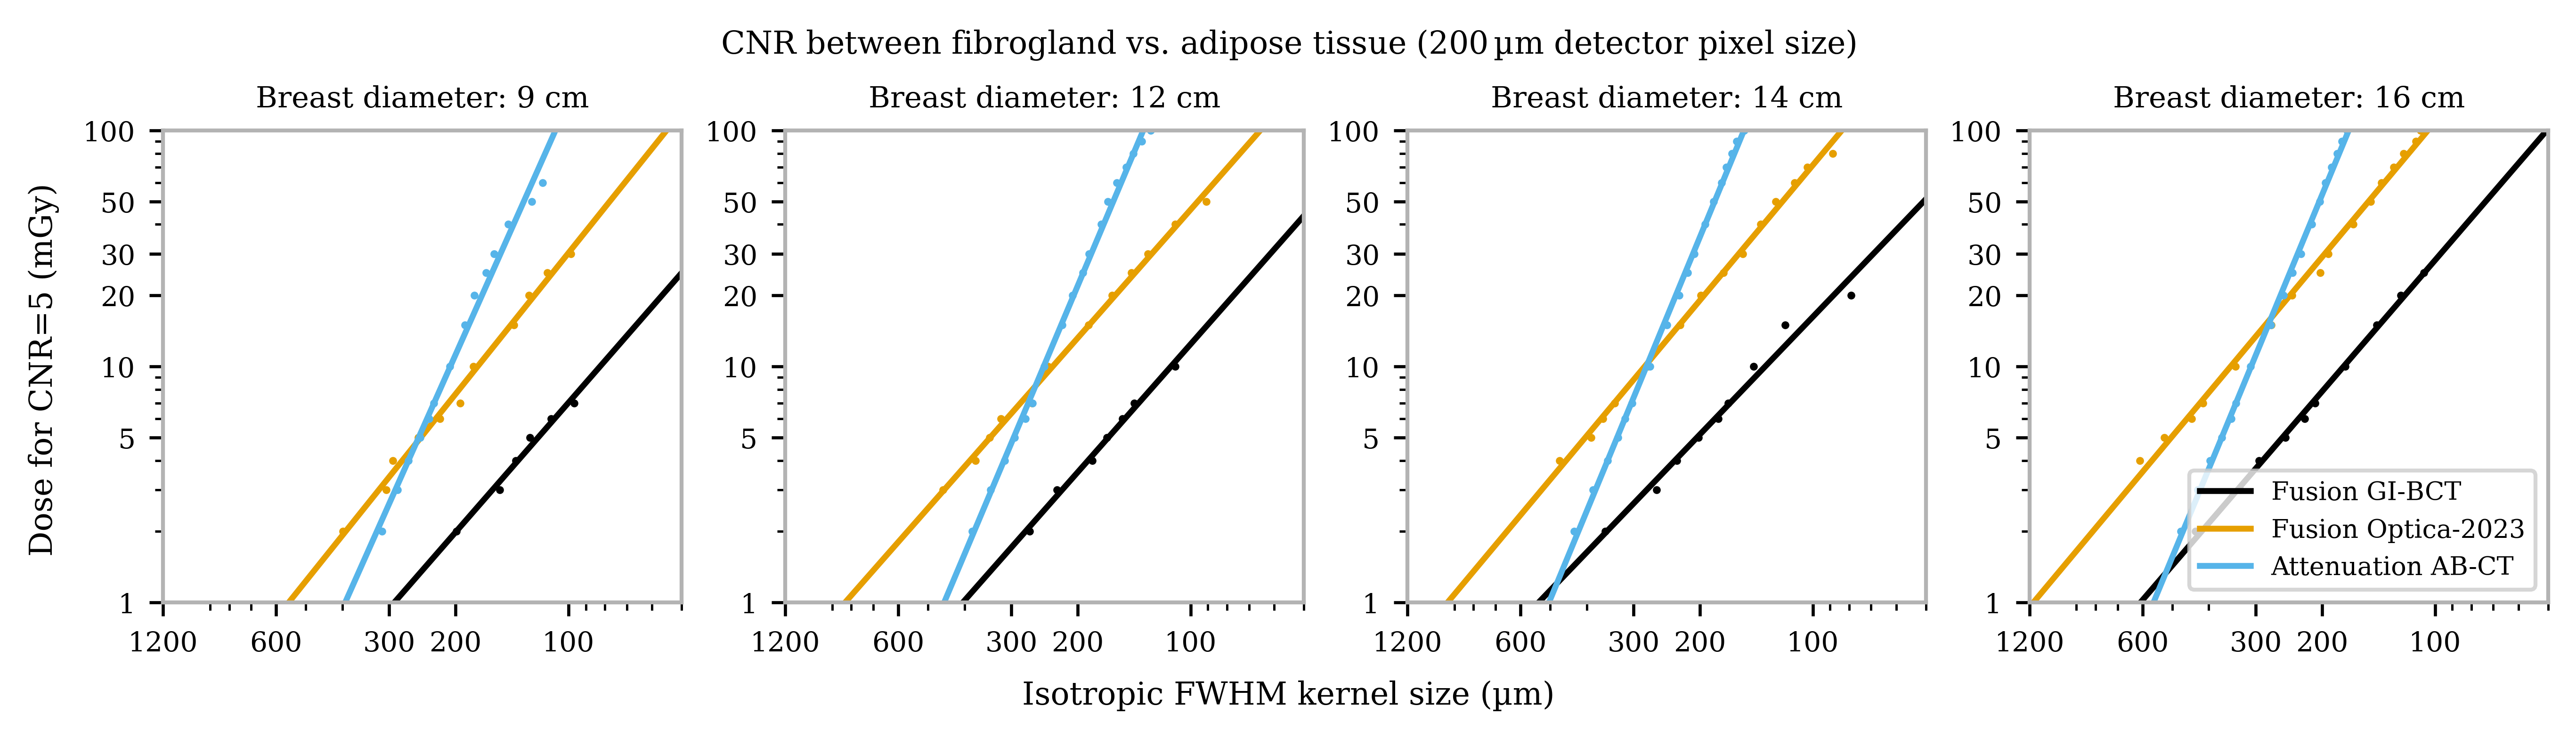

In [118]:
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(9, 2.5))
axs = axs.ravel()
x = np.linspace(50, 1200)

for i, bs in enumerate(breast_sizes[:]):
    # V2
    fwhm_att = np.r_[sigmas_att[str(bs)]] * 2.355 * voxel_size_v2 *1e4
    fwhm_ph = np.r_[sigmas_ph[str(bs)]] * 2.355 * voxel_size_v2 *1e4
    fwhm_fus = np.r_[sigmas_fus[str(bs)]] * 2.355 * voxel_size_v2 *1e4
    
    
    # Static
    fwhm_att_static = np.r_[sigmas_att_static[str(bs)]] * 2.355 * voxel_size_static *1e4
    fwhm_ph_static = np.r_[sigmas_ph_static[str(bs)]] * 2.355 * voxel_size_static *1e4
    fwhm_fus_static = np.r_[sigmas_fus_static[str(bs)]] * 2.355 * voxel_size_static *1e4

    # nuview
    fwhm_att_abct = np.r_[sigmas_att_abct[str(bs)]] * 2.355 * voxel_size_abct *1e4
    
    
    # V2
    plot_curve_if_possible_binned(axs[i], x, fwhm_fus, doses, colors[0], "Fusion GI-BCT")
    
    # Static
    plot_curve_if_possible_binned(axs[i], x, fwhm_fus_static, doses, colors[1], "Fusion Optica-2023")
    
    # nuview
    plot_curve_if_possible_binned(axs[i], x, fwhm_att_abct, doses, colors[2], "Attenuation AB-CT")

    #plt.axvspan(150, 300, color="0.9")

    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    axs[i].invert_xaxis()
    axs[i].set_xlim(1200, 50)
    axs[i].set_ylim(1, 100)
    axs[i].set_xticks([1200, 600, 300, 200,  100])
    axs[i].set_xticklabels(map(str, [1200, 600, 300, 200, 100]), fontsize = 7)
    axs[i].set_yticks([1, 5, 10, 20, 30, 50, 100])
    axs[i].set_yticklabels(map(str, [1, 5, 10, 20, 30, 50, 100]), fontsize = 7)
    #axs[i].set_xlabel("isotropic FWHM kernel size (um)")
    #axs[i].set_ylabel(f"dose for CNR={target_cnr} (mGy)")
    axs[i].set_title(f"Breast diameter: {bs} cm", fontsize = 7.5)

fig.supylabel(f"Dose for CNR={target_cnr} (mGy)", fontsize = 8)
fig.supxlabel(f"Isotropic FWHM kernel size (µm)", fontsize = 8)


    
axs[-1].legend(fontsize=6.5, frameon=True)

fig.suptitle(r"CNR between fibrogland vs. adipose tissue (200$\,$µm detector pixel size)", fontsize = 8)

#plt.savefig('data/CNR_fibrogland_adipose_binned_slim_cone_visHard.png', bbox_inches = 'tight')

In [119]:
np.delete(fwhm_ph, 1)

array([714.17943844, 350.98441383, 329.08986637, 251.58742113,
       245.25069406, 206.49129792, 153.16508963, 130.00299048,
       114.82256225, 103.94371143,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ])

# Fibrogland Tumor

In [121]:
# Sigmas for Fusion according to NPS
binning = 2
voxel_size_v2 = 62.141479456616764 * 1e-4 * binning
voxel_size_abct = 76.92307692307692 * 1e-4 * binning
voxel_size_static = 58.6405529953917 * 1e-4 * binning

with open(os.path.join(storage, f"{system}_tumor/{system}_cutoff_kernel.json"), 'r') as f:
    cutoff_kernels_v2 = json.load(f)
    
with open(os.path.join(storage, f"{system_static}_tumor/{system_static}_cutoff_kernel.json"), 'r') as f:
    cutoff_kernels_static = json.load(f)

# Sigmas for filtering for CNR of 5
with open(os.path.join(storage, f"{system}_tumor/{system}_attenuation_TF_wR_L.json"), "r") as f:
    sigmas_att = json.load(f)
with open(os.path.join(storage, f"{system}_tumor/{system}_refraction_TF_wR_L.json"), "r") as f:
    sigmas_ph = json.load(f)
with open(os.path.join(storage, f"{system}_tumor/{system}_fused_TF_wR_L.json"), "r") as f:
    sigmas_fus = json.load(f)

#Static
with open(os.path.join(storage, f"{system_static}_tumor/{system_static}_attenuation_TF_wR_L.json"), "r") as f:
    sigmas_att_static = json.load(f)
with open(os.path.join(storage, f"{system_static}_tumor/{system_static}_refraction_TF_wR_L.json"), "r") as f:
    sigmas_ph_static = json.load(f)
with open(os.path.join(storage, f"{system_static}_tumor/{system_static}_fused_TF_wR_L.json"), "r") as f:
    sigmas_fus_static = json.load(f)
    
    
# Sigmas for filtering for CNR of 5
with open(os.path.join(storage, f"{system_abct}_tumor/{system_abct}_attenuation_TF_L.json"), "r") as f:
    sigmas_att_abct = json.load(f)

## Plot CNR curves

In [122]:
breast_sizes = [9, 12, 14, 16]
#doses = np.array([3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100])
target_cnr = 5
fibro_circle, adi_circle, tumor_circle, phantom = get_area_roi(sample_size_cm, system = system)

In [123]:
linestyles = ['-', '--', '-.', ':']

In [124]:
#colors = ["C0", "C1", "C2", "C3", "C4", "C5","C6", 'C7', "C8", "C9"]
linestyles = ['-', '--', '-.', ':', '-', '--']

In [125]:

def plot_curve_if_possible_binned(ax, x, fwhm, dose, color, label):
    # Check for outliers
    residuals = np.abs(fwhm - np.mean(fwhm[fwhm>0]))
    #print(residuals)
    #print(np.mean(fwhm[fwhm>0]))
    non_outliers = residuals < 2*np.mean(fwhm[fwhm>0])
    print(non_outliers)
    fwhm = fwhm[non_outliers]
    dose = dose[non_outliers]

    if len(fwhm[fwhm>0]) >= 2:
        a, b = np.polyfit(np.log(fwhm[fwhm> 0]), np.log(dose[fwhm > 0]), 1)
        ax.plot(x, np.exp(b) * x**a, color=color, linestyle=linestyles[0], label=label)
        ax.plot(fwhm, dose, "o", color=color)
    else:
        pass

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[

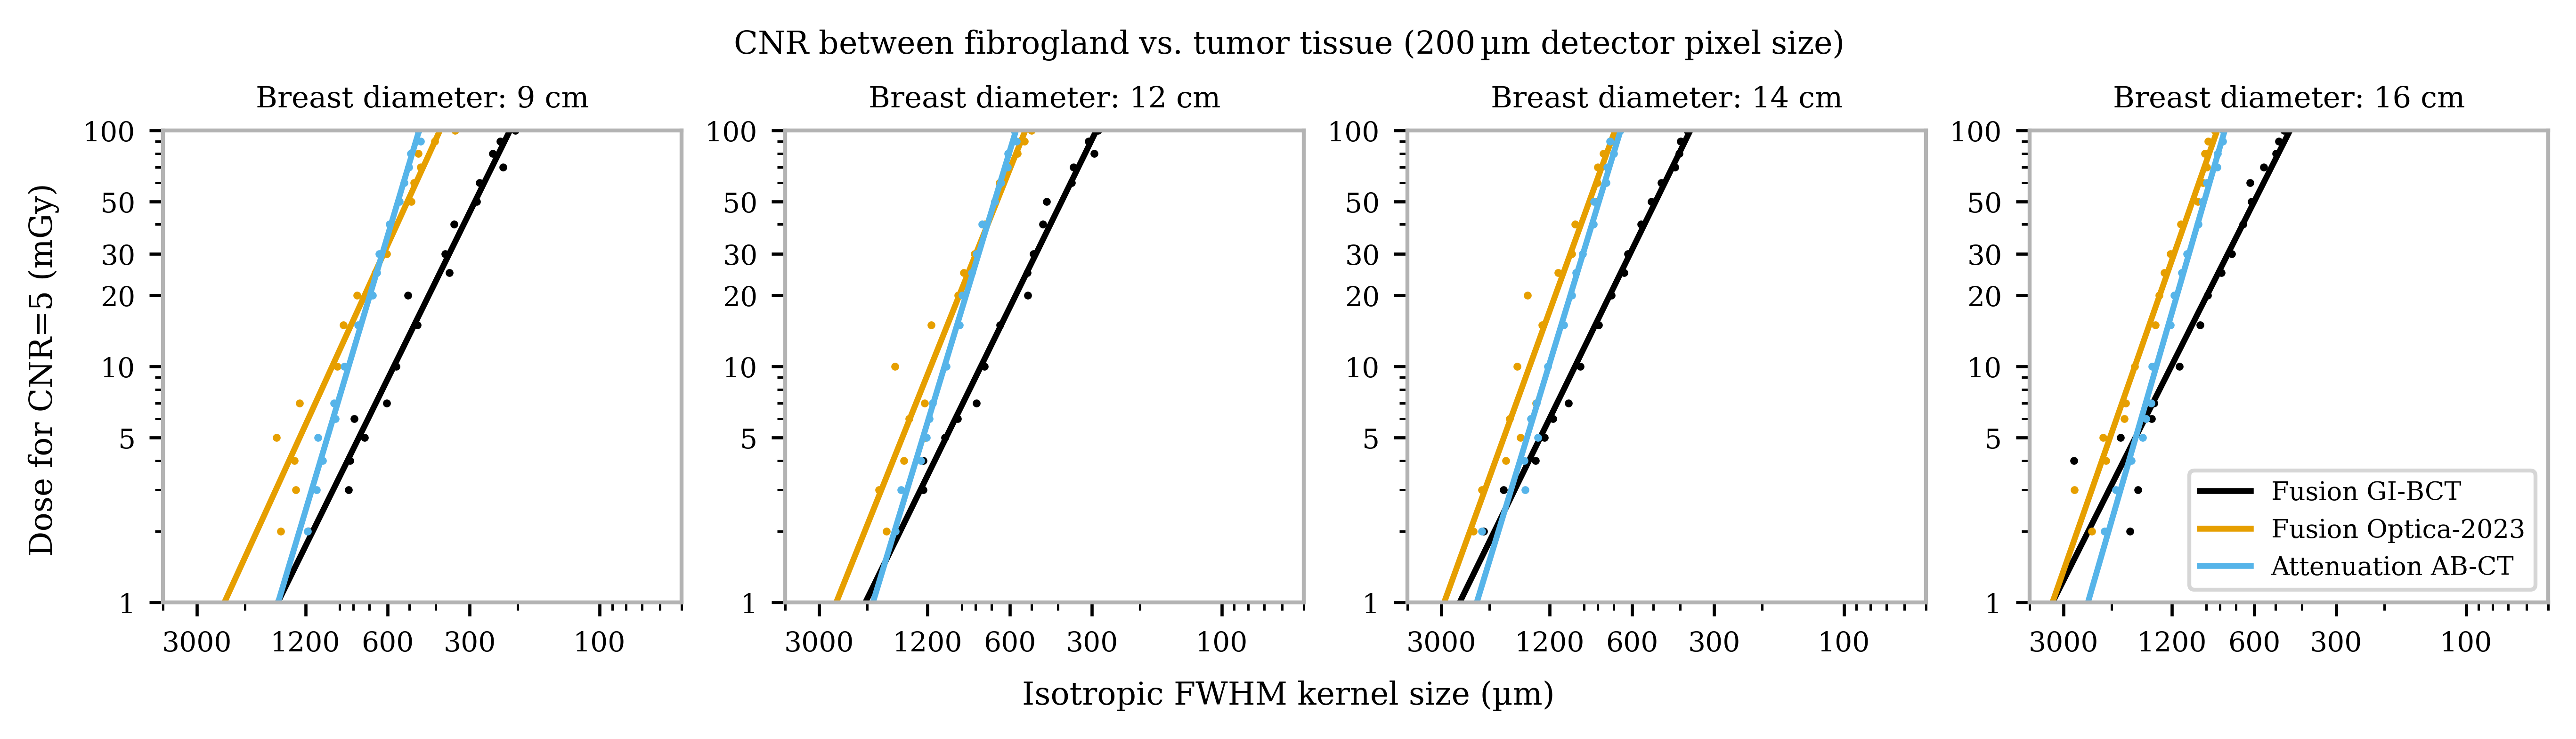

In [126]:
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(9, 2.5))
axs = axs.ravel()
x = np.linspace(50, 4000)

for i, bs in enumerate(breast_sizes[:]):
    # V2
    fwhm_att = np.r_[sigmas_att[str(bs)]] * 2.355 * voxel_size_v2 *1e4
    fwhm_ph = np.r_[sigmas_ph[str(bs)]] * 2.355 * voxel_size_v2 *1e4
    fwhm_fus = np.r_[sigmas_fus[str(bs)]] * 2.355 * voxel_size_v2 *1e4
    
    
    # Static
    fwhm_att_static = np.r_[sigmas_att_static[str(bs)]] * 2.355 * voxel_size_static *1e4
    fwhm_ph_static = np.r_[sigmas_ph_static[str(bs)]] * 2.355 * voxel_size_static *1e4
    fwhm_fus_static = np.r_[sigmas_fus_static[str(bs)]] * 2.355 * voxel_size_static *1e4

    # nuview
    fwhm_att_abct = np.r_[sigmas_att_abct[str(bs)]] * 2.355 * voxel_size_abct *1e4
    
    
    # V2
    plot_curve_if_possible_binned(axs[i], x, fwhm_fus, doses, colors[0], "Fusion GI-BCT")
    
    # Static
    plot_curve_if_possible_binned(axs[i], x, fwhm_fus_static, doses, colors[1], "Fusion Optica-2023")
    
    # nuview
    plot_curve_if_possible_binned(axs[i], x, fwhm_att_abct, doses, colors[2], "Attenuation AB-CT")


    #plt.axvspan(150, 300, color="0.9")

    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    axs[i].invert_xaxis()
    axs[i].set_xlim(4000, 50)
    axs[i].set_ylim(5, 100)
    axs[i].set_xticks([3000, 1200, 600, 300, 100])
    axs[i].set_xticklabels(map(str, [3000, 1200, 600, 300, 100]), fontsize = 7)
    axs[i].set_yticks([1, 5, 10, 20, 30, 50, 100])
    axs[i].set_yticklabels(map(str, [1, 5, 10, 20, 30, 50, 100]), fontsize = 7)
    #axs[i].set_xlabel("isotropic FWHM kernel size (um)")
    #axs[i].set_ylabel(f"dose for CNR={target_cnr} (mGy)")
    axs[i].set_title(f"Breast diameter: {bs} cm", fontsize = 7.5)

fig.supylabel(f"Dose for CNR={target_cnr} (mGy)", fontsize = 8)
fig.supxlabel(f"Isotropic FWHM kernel size (µm)", fontsize = 8)


    
axs[-1].legend(fontsize=6.5, frameon=True)

fig.suptitle(r"CNR between fibrogland vs. tumor tissue (200$\,$µm detector pixel size)", fontsize = 8)

#plt.savefig('data/CNR_fibrogland_tumor_binned_slim_cone_visHard.png', bbox_inches = 'tight')

# Tumor Adipose

In [127]:
# Sigmas for Fusion according to NPS
binning = 2
voxel_size_v2 = 62.141479456616764 * 1e-4 * binning
voxel_size_abct = 76.92307692307692 * 1e-4 * binning
voxel_size_static = 58.6405529953917 * 1e-4 * binning

with open(os.path.join(storage, f"{system}_tumor/{system}_cutoff_kernel.json"), 'r') as f:
    cutoff_kernels_v2 = json.load(f)
    
with open(os.path.join(storage, f"{system_static}_tumor/{system_static}_cutoff_kernel.json"), 'r') as f:
    cutoff_kernels_static = json.load(f)

# Sigmas for filtering for CNR of 5
with open(os.path.join(storage, f"{system}_tumor/{system}_attenuation_TA_wR_L.json"), "r") as f:
    sigmas_att = json.load(f)
with open(os.path.join(storage, f"{system}_tumor/{system}_refraction_TA_wR_L.json"), "r") as f:
    sigmas_ph = json.load(f)
with open(os.path.join(storage, f"{system}_tumor/{system}_fused_TA_wR_L.json"), "r") as f:
    sigmas_fus = json.load(f)

#Static
with open(os.path.join(storage, f"{system_static}_tumor/{system_static}_attenuation_TA_wR_L.json"), "r") as f:
    sigmas_att_static = json.load(f)
with open(os.path.join(storage, f"{system_static}_tumor/{system_static}_refraction_TA_wR_L.json"), "r") as f:
    sigmas_ph_static = json.load(f)
with open(os.path.join(storage, f"{system_static}_tumor/{system_static}_fused_TA_wR_L.json"), "r") as f:
    sigmas_fus_static = json.load(f)
    
    
# Sigmas for filtering for CNR of 5
with open(os.path.join(storage, f"{system_abct}_tumor/{system_abct}_attenuation_TA_L.json"), "r") as f:
    sigmas_att_abct = json.load(f)

## Plot CNR curves

In [128]:
breast_sizes = [9, 12, 14, 16]
#doses = np.array([3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100])
target_cnr = 5
fibro_circle, adi_circle, tumor_circle, phantom = get_area_roi(sample_size_cm, system = system)

In [129]:
linestyles = ['-', '--', '-.', ':']

In [130]:
#colors = ["C0", "C1", "C2", "C3", "C4", "C5","C6", 'C7', "C8", "C9"]
linestyles = ['-', '--', '-.', ':', '-', '--']

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[

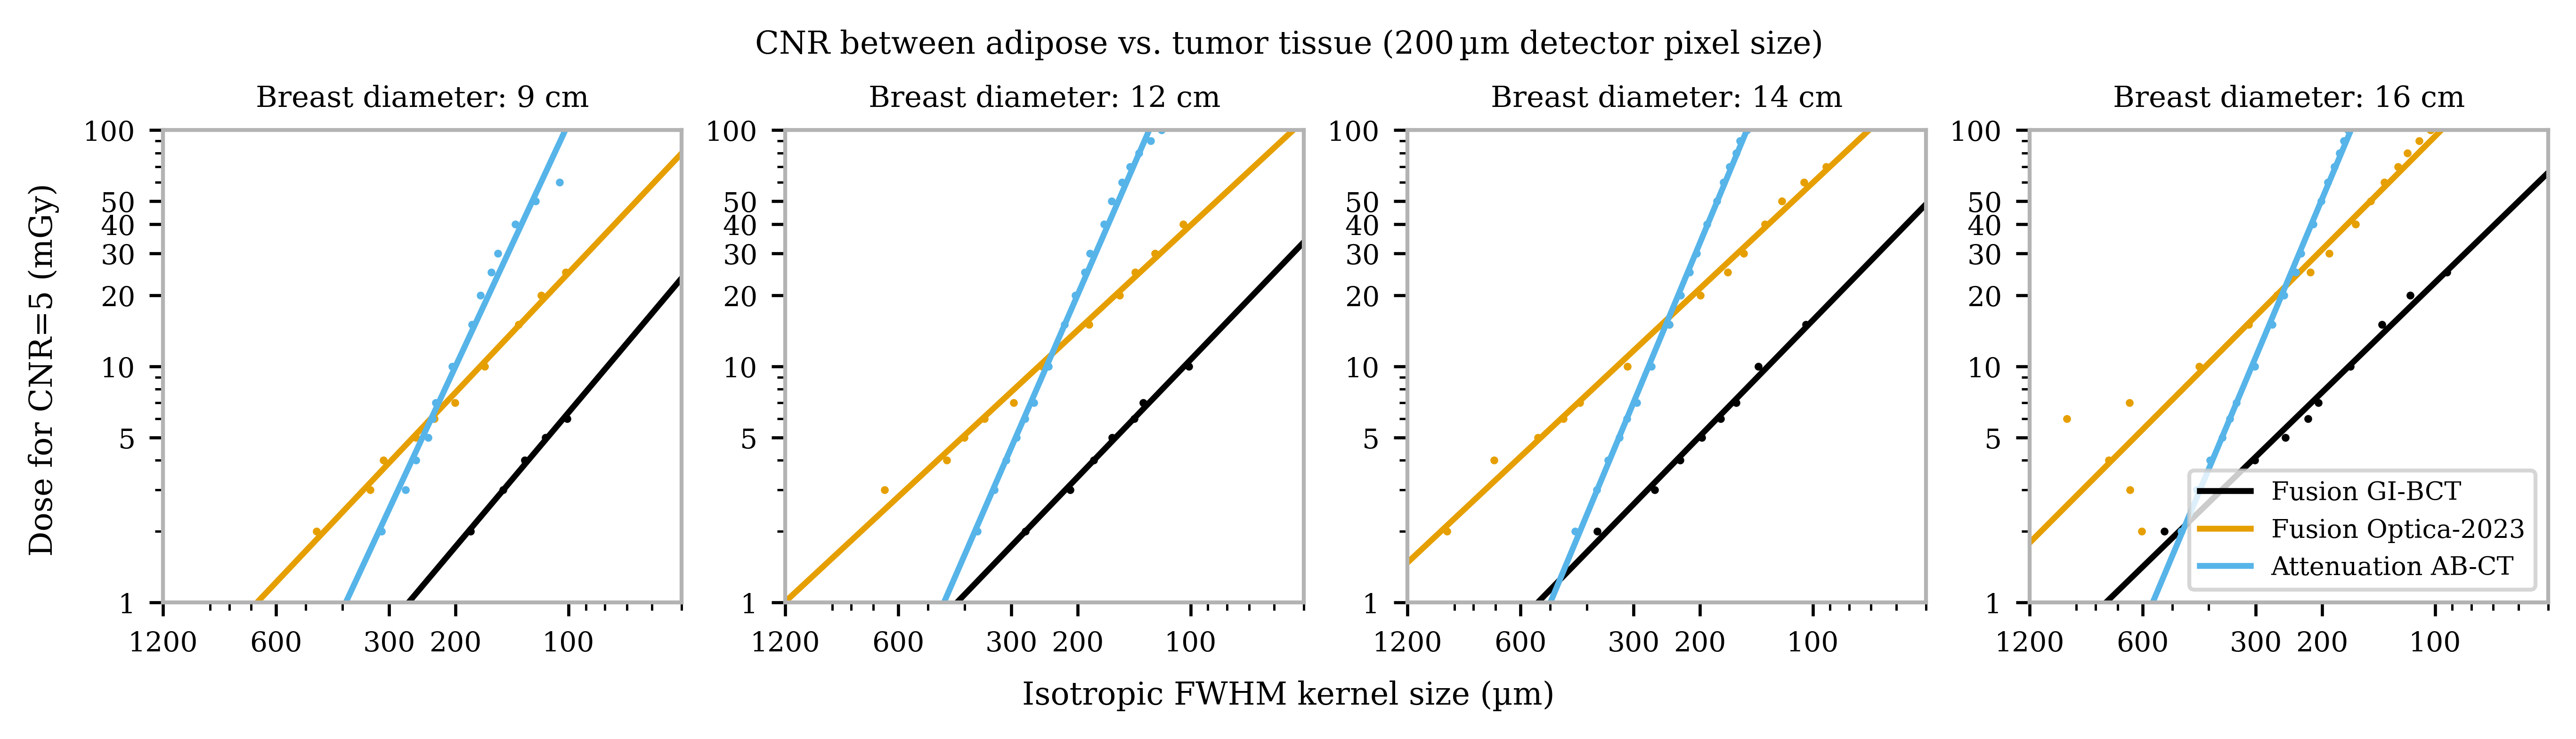

In [131]:
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(9, 2.5))
axs = axs.ravel()
x = np.linspace(50, 1200)

for i, bs in enumerate(breast_sizes[:]):
    # V2
    fwhm_att = np.r_[sigmas_att[str(bs)]] * 2.355 * voxel_size_v2 *1e4
    fwhm_ph = np.r_[sigmas_ph[str(bs)]] * 2.355 * voxel_size_v2 *1e4
    fwhm_fus = np.r_[sigmas_fus[str(bs)]] * 2.355 * voxel_size_v2 *1e4
    
    
    # Static
    fwhm_att_static = np.r_[sigmas_att_static[str(bs)]] * 2.355 * voxel_size_static *1e4
    fwhm_ph_static = np.r_[sigmas_ph_static[str(bs)]] * 2.355 * voxel_size_static *1e4
    fwhm_fus_static = np.r_[sigmas_fus_static[str(bs)]] * 2.355 * voxel_size_static *1e4

    # nuview
    fwhm_att_abct = np.r_[sigmas_att_abct[str(bs)]] * 2.355 * voxel_size_abct *1e4
    
    
    # V2
    plot_curve_if_possible_binned(axs[i], x, fwhm_fus, doses, colors[0], "Fusion GI-BCT")
    
    # Static
    plot_curve_if_possible_binned(axs[i], x, fwhm_fus_static, doses, colors[1], "Fusion Optica-2023")
    
    # nuview
    plot_curve_if_possible_binned(axs[i], x, fwhm_att_abct, doses, colors[2], "Attenuation AB-CT")


    #plt.axvspan(150, 300, color="0.9")

    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    axs[i].invert_xaxis()
    axs[i].set_xlim(1200, 50)
    axs[i].set_ylim(1, 100)
    axs[i].set_xticks([1200, 600, 300, 200,  100])
    axs[i].set_xticklabels(map(str, [1200, 600, 300, 200, 100]), fontsize = 7)
    axs[i].set_yticks([1, 5, 10, 20, 30, 40, 50, 100])
    axs[i].set_yticklabels(map(str, [1, 5, 10, 20, 30, 40, 50, 100]), fontsize = 7)
    #axs[i].set_xlabel("isotropic FWHM kernel size (um)")
    #axs[i].set_ylabel(f"dose for CNR={target_cnr} (mGy)")
    axs[i].set_title(f"Breast diameter: {bs} cm", fontsize = 7.5)

fig.supylabel(f"Dose for CNR={target_cnr} (mGy)", fontsize = 8)
fig.supxlabel(f"Isotropic FWHM kernel size (µm)", fontsize = 8)


    
axs[-1].legend(fontsize=6.5, frameon=True)

fig.suptitle(r"CNR between adipose vs. tumor tissue (200$\,$µm detector pixel size)", fontsize = 8)
#plt.savefig('data/CNR_tumor_adipose_binned_slim_cone_visHard.png', bbox_inches = 'tight')

# Combine all plots to a single plot

In [132]:
# from PIL import Image

# im1 = plt.imread('data/CNR_fibrogland_adipose_binned_slim_cone_visHard.png')
# im2 = plt.imread('data/CNR_tumor_adipose_binned_slim_cone_visHard.png')
# im3 = plt.imread('data/CNR_fibrogland_tumor_binned_slim_cone_visHard.png')

# #im1 = np.asarray(im1) 

In [155]:
# 18/2.54

7.086614173228346

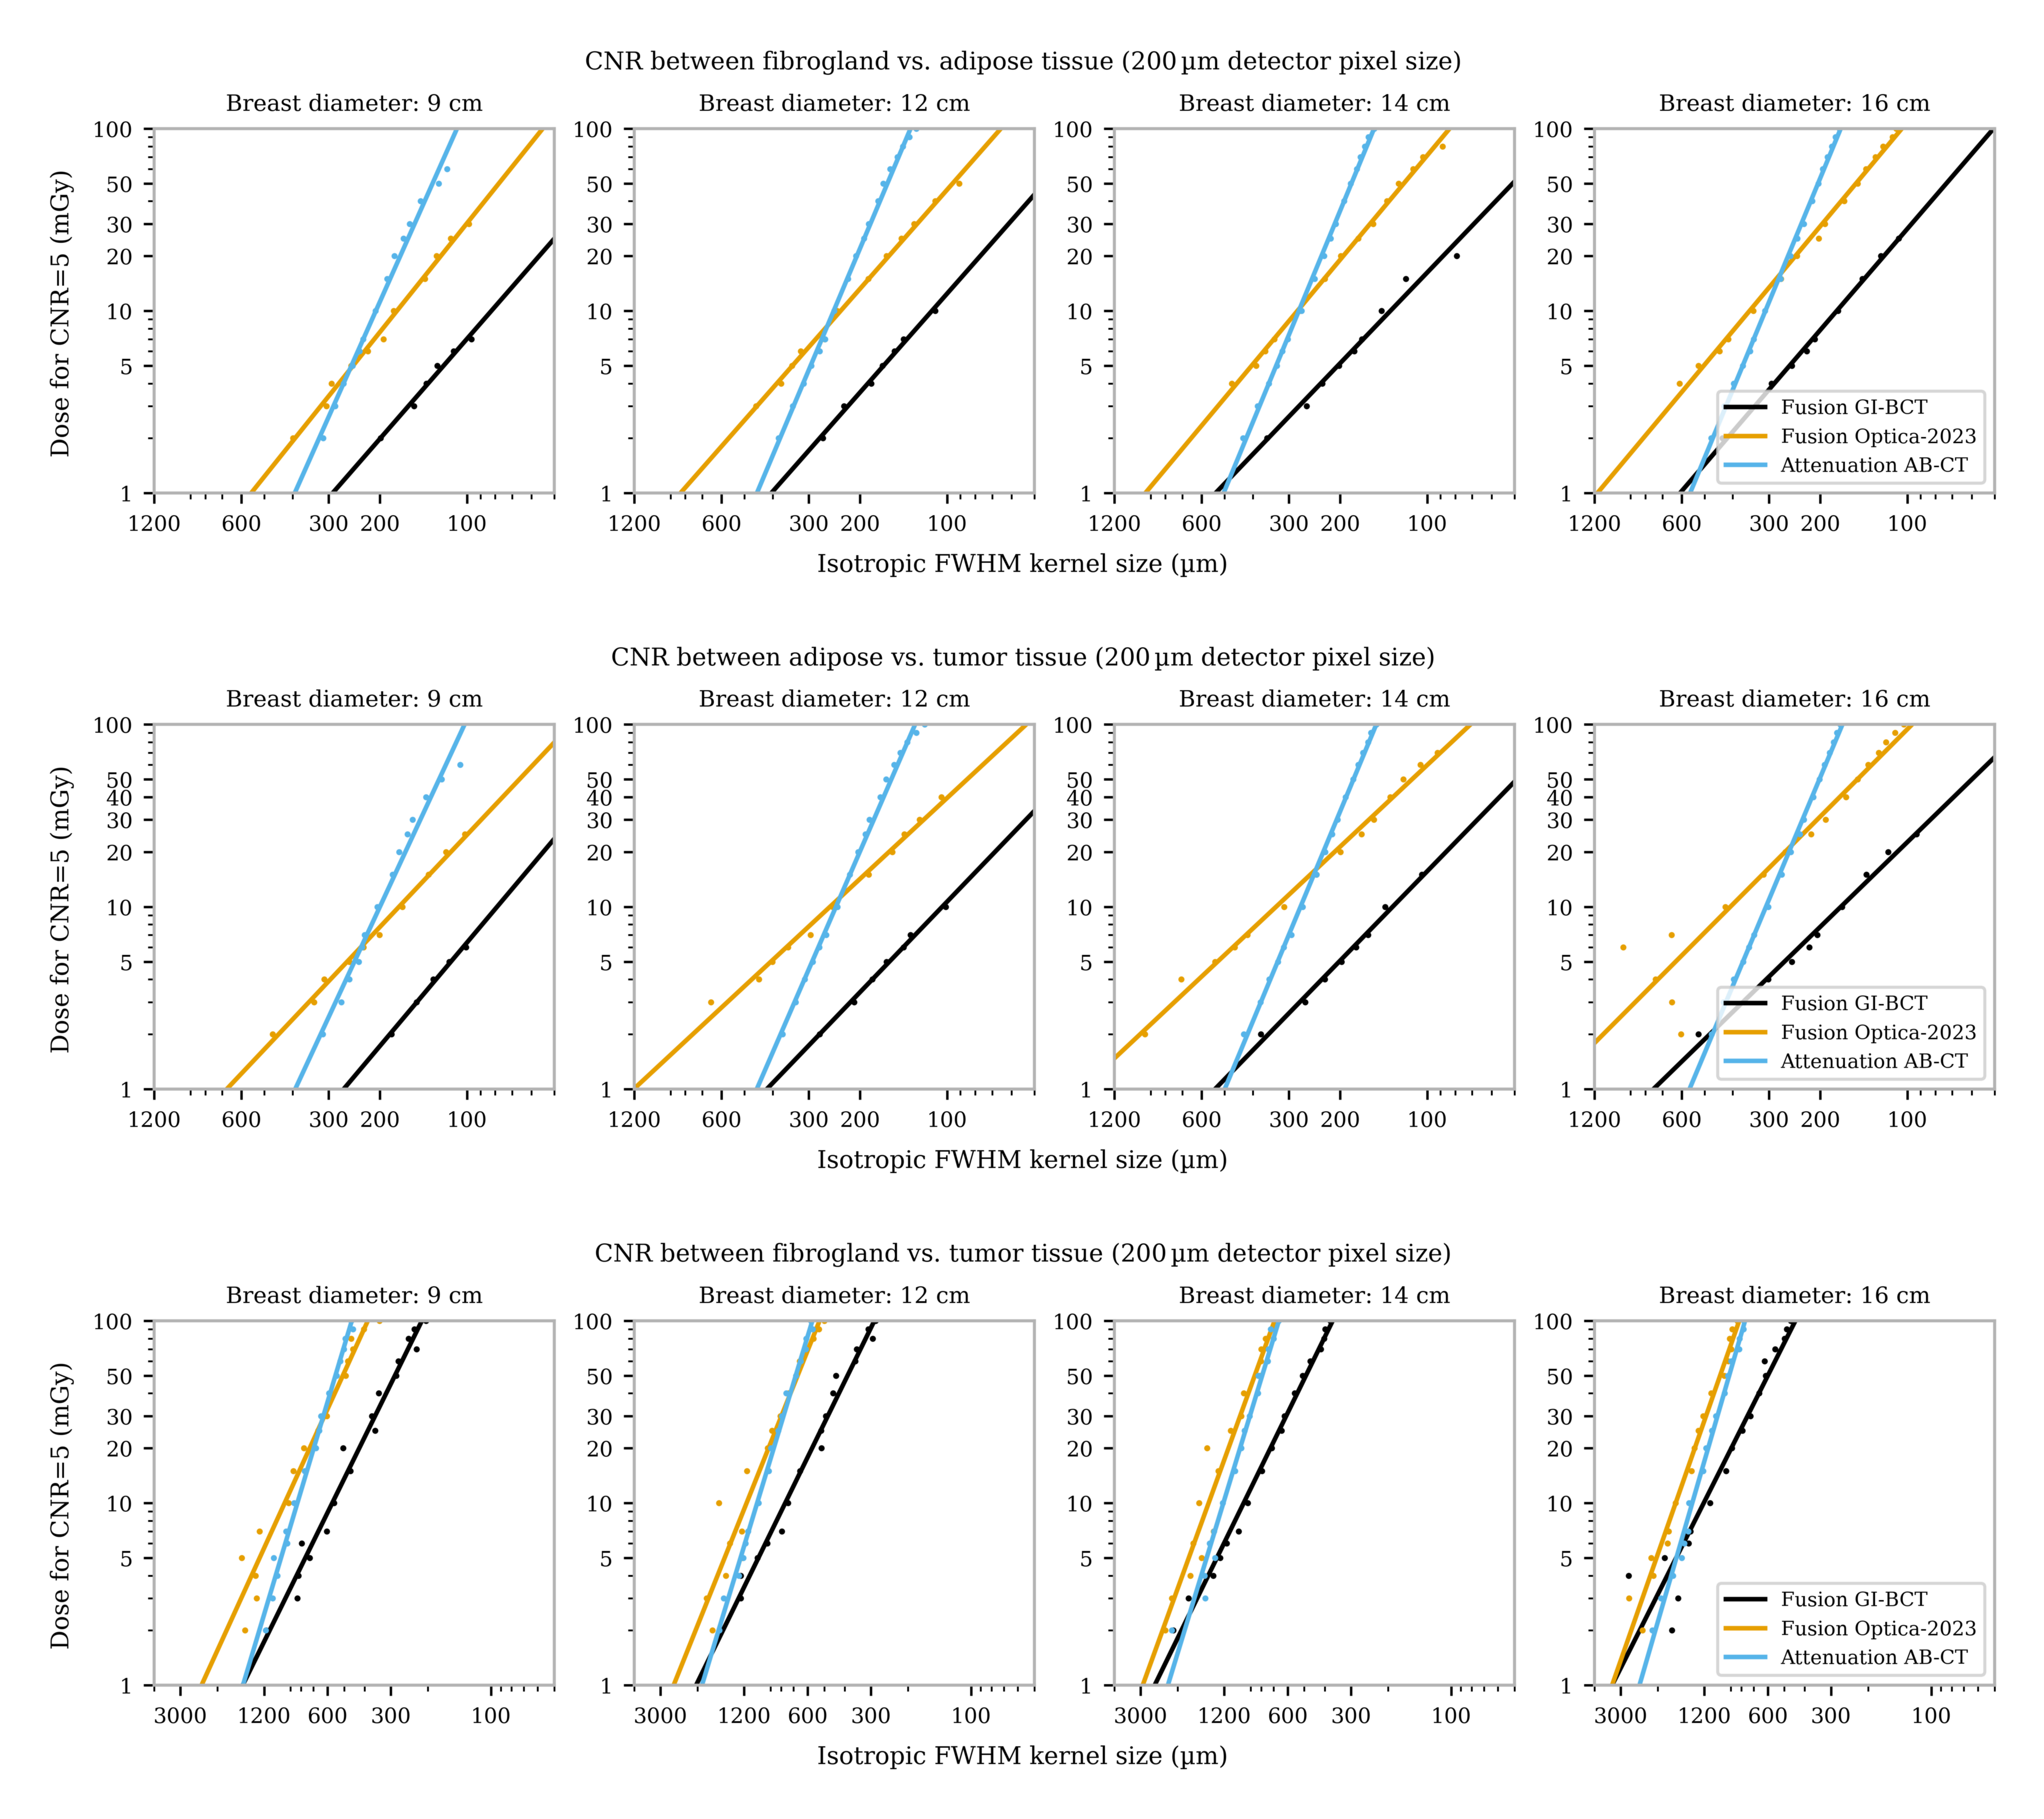

In [157]:
# im1 = plt.imread('data/CNR_fibrogland_adipose_binned_slim_cone_visHard.png')
# im2 = plt.imread('data/CNR_tumor_adipose_binned_slim_cone_visHard.png')
# im3 = plt.imread('data/CNR_fibrogland_tumor_binned_slim_cone_visHard.png')

# fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize= (18/2.54, 16/2.54))

# ax[0].imshow(im1, resample=True)
# ax[1].imshow(im2, resample=True)
# ax[2].imshow(im3, resample=True)

# for axs in ax:
#     axs.axis('off')
    
# plt.savefig('data/Figure_5.pdf', format = 'pdf', bbox_inches = 'tight', dpi = 600)